In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [2]:
root_path = Path("/Users/adminnistrator/Documents/Stanford/STATS 207/STATS-207-Final-Project")

In [3]:
electricity_data = pd.read_csv(root_path / "clean_data.csv")

# Aggregate the data: compute the monthly average electricity price at the national level
electricity_data['date'] = pd.to_datetime(
    electricity_data[['year', 'month']].assign(day=1)
)  # Create a date column for time series analysis

# Calculate the monthly average price
national_avg_price = electricity_data.groupby('date')['price'].mean().reset_index()

national_avg_price.to_csv(root_path / "national_avg_price.csv", index = False)

In [4]:
national_avg_price['date'] = pd.to_datetime(national_avg_price['date'])
national_avg_price.set_index('date', inplace=True)
national_avg_price.head()

,price
date,
2001-01-01,7.136839
2001-02-01,7.271097
2001-03-01,7.443806
2001-04-01,7.544065
2001-05-01,7.675194


In [11]:
def create_lagged_features(data, lag=1):
    """
    Create lagged features for supervised learning.
    :param data: Input time series (numpy array or pandas Series).
    :param lag: Number of lagged observations to include.
    :return: Feature matrix X and target vector y.
    """
    X, y = [], []
    for i in range(len(data) - lag):
        X.append(data[i:i + lag])
        y.append(data[i + lag])
    return np.array(X), np.array(y)

# Function to create and compile LSTM model
def create_lstm_model(input_shape):
    # Use the Input layer to specify the input shape
    inputs = Input(shape=input_shape)
    x = LSTM(50, activation='relu')(inputs)  # Add LSTM layer after Input
    outputs = Dense(1)(x)  # Output layer
    model = Model(inputs=inputs, outputs=outputs)  # Create the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to create and compile the LSTM model
def create_tuned_lstm_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential([
        Input(shape=input_shape),  # Define input shape explicitly
        LSTM(units, return_sequences=False),  # LSTM layer
        Dropout(dropout_rate),  # Dropout for regularization
        Dense(1)  # Output layer for regression
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [12]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(national_avg_price)

# Create lagged features with a window size of 12
lag = 12
X, y = create_lagged_features(data_normalized, lag)

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [13]:
param_grid = {
    'units': [16, 32, 64],                # Number of LSTM units
    'dropout_rate': [0.1, 0.2, 0.3],      # Dropout rate
    'learning_rate': [0.001, 0.01],       # Learning rate
    'batch_size': [16, 32],               # Batch size
    'epochs': [30, 50]                    # Number of epochs
}

# Grid search for hyperparameter tuning
best_rmse = float('inf')
best_params = {}
results = []

# For plotting purposes
tscv = TimeSeriesSplit(n_splits=5)
all_rmse = []

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    rmse_values = []
                    print(f"Testing configuration: units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")
                    
                    for train_index, test_index in tscv.split(X):
                        X_train, X_test = X[train_index], X[test_index]
                        y_train, y_test = y[train_index], y[test_index]

                        # Create the LSTM model with the current parameters
                        model = create_tuned_lstm_model(
                            input_shape=(X_train.shape[1], X_train.shape[2]),
                            units=units,
                            dropout_rate=dropout_rate,
                            learning_rate=learning_rate
                        )

                        # Train the model
                        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

                        # Evaluate the model
                        y_pred = model.predict(X_test)
                        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                        rmse_values.append(rmse)

                    # Average RMSE across folds
                    avg_rmse = np.mean(rmse_values)
                    all_rmse.append((avg_rmse, units, dropout_rate, learning_rate, batch_size, epochs))
                    print(f"Average RMSE: {avg_rmse:.4f}")

                    # Save the best configuration
                    if avg_rmse < best_rmse:
                        best_rmse = avg_rmse
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

Testing configuration: units=16, dropout_rate=0.1, learning_rate=0.001, batch_size=16, epochs=30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Average RMSE: 0.0807
Testing configuration: units=16, dropout_rate=0.1, learning_rate=0.001, batch_size=16, epochs=50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Average RMSE: 0.0740
Testing configuration: units=16, dropout_rate=0.1, learning_rate=0.001, batch_size=32, epochs=30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Average RMSE: 0.0859
Testing configuration: units=16, dropout_rate=0.1, learning_rate=0.001, batc

In [14]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")


Best Hyperparameters:
{'units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 50}
Best RMSE: 0.0319


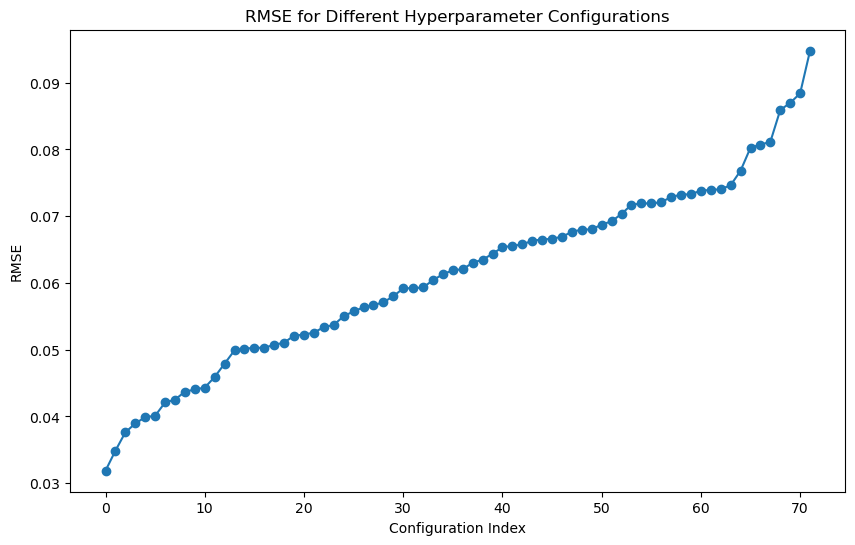

In [15]:
# Plot RMSE for different configurations
all_rmse_sorted = sorted(all_rmse, key=lambda x: x[0])
rmse_values_plot = [x[0] for x in all_rmse_sorted]

plt.figure(figsize=(10, 6))
plt.plot(range(len(rmse_values_plot)), rmse_values_plot, marker='o')
plt.title('RMSE for Different Hyperparameter Configurations')
plt.xlabel('Configuration Index')
plt.ylabel('RMSE')
plt.show()